Using KMeans to cluster the customers based on their account activity, and then examine the demographic data of each group to see if they differ in a meaningful way.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df=pd.read_csv('BankChurners.csv')

In [3]:
del df['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1']
del df['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
df = df.drop(columns = ['CLIENTNUM'])

In [4]:
df.shape

(10127, 20)

Skew Features

In [5]:
# Select numerical variables
numeric = df.select_dtypes(exclude=object).columns

skew_limit = 0.5
skew_vals = df[numeric].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
Total_Ct_Chng_Q4_Q1,2.064031
Total_Trans_Amt,2.041003
Total_Amt_Chng_Q4_Q1,1.732063
Credit_Limit,1.666726
Avg_Open_To_Buy,1.661697
Avg_Utilization_Ratio,0.718008
Months_Inactive_12_mon,0.633061


In our case, we'll use the Box-Cox transformation to transform all the skew features into a normal distribution.

In [6]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Normalize skewed features
for col in skew_cols.index:
   df[col] = np.log1p(df[col])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  float64
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

When using KMeans, we have to specify the number of clusters the algorithm will use. One way to find the ideal number of clusters is the elbow method.

The elbow method allows us to identify at which K value the sum of squared distance, or the distance between data points and their respective centroids, begins to level off.

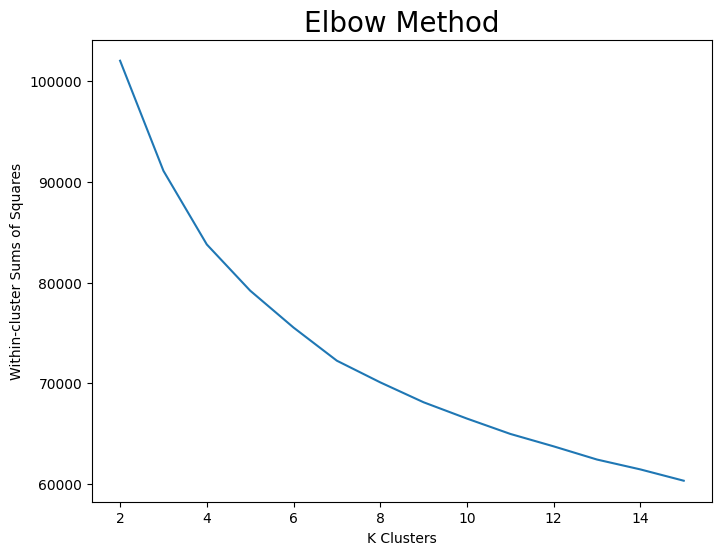

In [11]:
cols = df.iloc[:, 7:].select_dtypes(['int64', 'float64']).columns

wcss = []

for i in range(2,16):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=1)
    data = StandardScaler().fit_transform(df[cols])
    km.fit(data)
    wcss.append(km.inertia_)

fig = plt.figure(figsize=(8,6))
ax = sns.lineplot(x=range(2,16), y=wcss)
ax.set_title('Elbow Method')
ax.title.set_size(20)
plt.xlabel('K Clusters')
plt.ylabel('Within-cluster Sums of Squares')
plt.show()

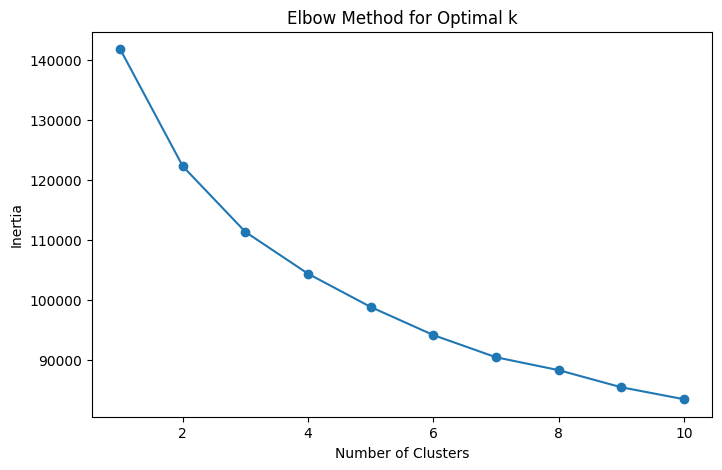

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Cluster
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,3,9.448727,777,9.385553,0.848012,7.043160,42,0.965081,0.059212,1
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,2,9.018817,864,8.908289,0.932558,7.163947,33,1.550537,0.099845,1
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,0,8.137103,0,8.137103,1.279266,7.543273,20,1.203873,0.000000,1
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,1,8.105911,2517,6.680855,0.877550,7.066467,20,1.203873,0.565314,0
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,0,8.458928,0,8.458928,1.155308,6.705639,28,1.252763,0.000000,1


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Örnek DataFrame (kendi veri kümenizi burada yükleyin)
# df = pd.read_csv('data.csv')

# 1. Sadece sayısal sütunları seç
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
data_numeric = df[numeric_columns]

# 2. Verileri standartlaştır
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# 3. Optimum küme sayısını belirleme (Elbow Method)
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Grafiği çizdir
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 4. K-means uygulama
optimal_k = 3  # Elbow Method'a göre belirlenen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Sonuçları DataFrame'e ekle
df['Cluster'] = clusters
df.head(5)


Silhouette Score Kullanımı:

In [12]:
from sklearn.metrics import silhouette_score

best_score = -1
best_k = 0

for i in range(2, 16):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=1)
    data = StandardScaler().fit_transform(df[cols])
    labels = km.fit_predict(data)
    score = silhouette_score(data, labels)
    print(f'K: {i}, Silhouette Score: {score}')
    
    if score > best_score:
        best_score = score
        best_k = i

print(f'En yüksek Silhouette Score: {best_score}, Optimal K: {best_k}')


K: 2, Silhouette Score: 0.1543347981945729
K: 3, Silhouette Score: 0.14755390183811207
K: 4, Silhouette Score: 0.1533027964384863
K: 5, Silhouette Score: 0.14063636480635588
K: 6, Silhouette Score: 0.1384709235566482
K: 7, Silhouette Score: 0.13246920759370498
K: 8, Silhouette Score: 0.1252648788884203
K: 9, Silhouette Score: 0.11407365498772329
K: 10, Silhouette Score: 0.10968431720049207
K: 11, Silhouette Score: 0.107760580608086
K: 12, Silhouette Score: 0.10852095126700355
K: 13, Silhouette Score: 0.10901625123211538
K: 14, Silhouette Score: 0.10991181051105946
K: 15, Silhouette Score: 0.10226246620914149
En yüksek Silhouette Score: 0.1543347981945729, Optimal K: 2
